# Segunda Lectura: Calculando Probabilidades

> __Alcance de la lectura:__ En esta segunda lectura, el alumno:
> * Utilizar funciones para reutilizar código. (Principio D.R.Y)
> * Convertir una formula matemática a una función en python
> * Construir y utilizar funciones orientadas al análisis de datos.
> * Optimizar funciones remplazandolas por funciones vectorizadas.
> * Utilizar conceptos básicos de probabilidad.
> * Generar segmentaciones de un `pd.DataFrame` en base a indexación y selección.

# Glosario

- Probabilidad
- Probabilidad condicional
- Función
  - parámetros
  - valores por defecto
  - retorno
- DRY
- tuplas


# Probabilidad Básica

* En esta sesión trabajaremos con una base de datos que registró todas las batallas de la Guerra de los Cinco Reyes, parte de la saga _A Song of Fire and Ice_ de George R.R. Martin. La base de datos la creó Chris Albon, un científico de datos con background en ciencias sociales.
* La base de datos y el libro de códigos asociado se encuentran en el siguiente repositorio de Github [https://github.com/chrisalbon/war_of_the_five_kings_dataset](https://github.com/chrisalbon/war_of_the_five_kings_dataset)
* Partamos por incluir los módulos con los cuales trabajamos la semana pasada

In [11]:
import pandas as pd
import numpy as np
import lec2_graphs as gfx
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.style.use('seaborn-whitegrid') # Gráficos estilo seaborn
plt.rcParams["figure.figsize"] = (10, 6) # Tamaño gráficos
plt.rcParams["figure.dpi"] = 200 # resolución gráficos

In [36]:
df = pd.read_csv('got_battles.csv')

* Revisemos las primeras observaciones con `head`.
* Cada observación ingresada en las filas representa una batalla dentro de la Guerra de los Cinco Reyes.
* Las columnas registran información sobre los participantes de la batalla, el tipo de batalla, resultados relevantes como la tasa de victorias del atacante, el tipo de batalla y muertes relevantes.


In [37]:
df.columns

Index(['me', 'year', 'battle_number', 'attacker_king', 'defender_king',
       'attacker_1', 'attacker_2', 'attacker_3', 'attacker_4', 'defender_1',
       'defender_2', 'defender_3', 'defender_4', 'attacker_outcome',
       'battle_type', 'major_death', 'major_capture', 'attacker_size',
       'defender_size', 'attacker_commander', 'defender_commander', 'summer',
       'location', 'region', 'note'],
      dtype='object')

* `shape` nos dice que tenemos una tabla de datos con 38 observaciones y 25 columnas.

In [38]:
df.shape

(38, 25)

* Analicemos los principales iniciadores de batallas. Para eso utilizamos la función `value_counts()` de `pandas` que devuelte una lista de la cantidad de objetos únicos en una Serie.

> Recuerden que cuando hablamos de Series, nos referimos a una lista unidimensional.

* Observamos que los Baratheon concentran 14 de 38 batallas, seguidos por los Starks. Stannis Baratheon, el "tío" de Joffrey, se posición como el que generó menos batallas con 5 de 35.

In [39]:
df['attacker_king'].value_counts()

Joffrey/Tommen Baratheon    14
Robb Stark                  10
Balon/Euron Greyjoy          7
Stannis Baratheon            5
Name: attacker_king, dtype: int64

* Estas cifras se conocen como frecuencias, que son la cantidad de eventos sobre el total muestral.
* Para obtener una panorámica más clara sobre los atacantes, podemos dividir cada cifra por el total de casos:

$$
\text{Pr(Evento)}=\frac{\text{Número de elementos del evento}}{\text{Posibles resultados en $\Omega$}}
$$

In [40]:
df['attacker_king'].value_counts() / len(df)

Joffrey/Tommen Baratheon    0.368421
Robb Stark                  0.263158
Balon/Euron Greyjoy         0.184211
Stannis Baratheon           0.131579
Name: attacker_king, dtype: float64

* Para obtener las frecuencias en términos porcentuales, podemos aplicar una división a nuestra operación con `value_counts`. Esto se conoce con __operación vectorizada__ y es un principio imporante en la programación orientada al análisis de datos.
* La operación vectorizada se puede resumir en la máxima: "_procurar utilizar operaciones en listas por sobre operaciones con iteradores_". 
* Esto suena complejo, pero simplemente es un principio rector para utilizar funciones que acepten vectores (listas como las `Series`) por sobre procesar cada elemento de una lista.
* Se observa que entre Joffrey y Tomen Baratheon se concentra el 37% de las batallas, seguidas por un 26% de Robb Stark.

## Definición clásica de probabilidad

* Estos porcentajes nos permite hablar de juicios de probabilidad.
* Acorde a los registros de las batallas, la probabilidad que una sea iniciada por un Baratheon (sumando Joffrey/Tommen y Stannis) es del 50%.
* Cuando realizamos una declaración probabilística como ésta, _generamos juicios sobre experimentos __aleatorios__ que producen una serie de resultados_.
* Cuando decimos que la probabilidad que un Baratheon inicie una batalla es del 50%, generamos un modelo de probabilidad con dos elementos:
    - Un _espacio muestral_ ($\Omega$) que hace referencia a todos los posibles resultados. En este caso, las 38 observaciones son el espacio muestral.
    - Una _función de probabilidad_ donde un elemento $A$ se le asigna un número no-negativo $\text{Pr}(A)$ que representa la verosimilitud de ocurrencia. En este caso, las 19 observaciones son el elemento $A$ que se convierten en $\text{Pr(AtaqueBaratheon)} = 19/38  \rightarrow .50$.
    
> __Digresión:__ Axiomas de Probabilidad.
>
> Toda probabilidad debe seguir conjunto de reglas que definen su comportamiento.
Dado un espacio muestral $\Omega$ para un experimento específico, la función de probabilidad asociada a éste debe satisfacer tres axiomas:
> 1. __Nonegatividad:__ $\text{Pr}(A) \geq 0 \forall A \subset \Omega$. Toda probabilidad dentro del espacio muestral será mayor a 0.
> 2. __Aditividad:__ Para eventos mutuamente excluyentes $a_{1}, a_{2}, \ldots$
> $$
\text{Pr}\left(\bigcup_{i = 1}^{\infty} a_i\right) = \sum_{i = 1}^{\infty} \text{Pr}(E_i)
$$
> 3. __Normalización:__ $\text{Pr}(\Omega) = 1$. La probabilidad del espacio muestral será 1.
> * En base a estos tres principios, se pueden derivar una serie de reglas generales sobre la probabilidad.


### Casos Independientes

* Por casos independientes hacemos referencia a eventos aislados que no están condicionados por otro.
* Un ejemplo de ésto es la probabilidad que se produzca una muerte importante (medida con la variable `major_death`)

In [1]:
df['major_death'].value_counts() / len(df)

NameError: name 'df' is not defined

* La variable está codificada como _dummy_, y toma dos valores: 1 para aquellas batallas que presentaron la muerte de un personaje importante; 0 para aquellas batallas que no.
* La información solicitada es que hay un 34% de probabilidad que en una batalla cualquiera muera un personaje importante.
* Decimos que es un evento independiente dado que si observamos dos batallas, el resultado de la primera no nos da información sobre la probabilidad de muerte de la segunda batalla.

### Casos Dependientes

* De forma lógica, un caso dependiente se refiere donde la ocurrencia de un evento depende de la ocurrencia de otro. 
* Siguiendo con el ejemplo de la probabilidad de muerte, un evento dependiente sería la probabilidad que el personaje haya estado enfermo antes o durante la batalla.
* El estar enfermo tiene una repercusión en la probabilidad de muerte, dado que afecta a su nivel de energía y preparación en la batalla.


### Probabilidad Condicional

* Imaginen que un ñoñazo adicto a George R.R Martin les pregunta por la probabilidad que muera un personaje importante cuando la batalla fue iniciada por un Baratheon.
* Para ello nos basamos en la __probabilidad condicional__. Ésta busca responder la verosimilitud de un evento $A$ sabiendo que sucede en $B$.
* Para obtener esta verosimilitud, debemos buscar la probabilidad $\text{Pr}(A|B)$ .

$$
\text{Pr}(A|B) = \frac{\text{Pr}(A \cap B )}{\text{Pr}(B)}
$$


* Partamos por definir los componentes del problema:

    * Evento A ($\text{Pr}(A)$): Probabilidad que la batalla haya presenciado una muerte importante.
    * Evento B ($\text{Pr}(B)$): Probabilidad que la batalla se haya originado por Joffrey o Tommen Baratheon.
    * Evento A __y__ B ($\text{Pr}(A \cap B)$): Probabilidad que se haya producido una muerte importante __en__ un batalla la originó Joffrey o Tommen Baratheon.


* El evento $\text{Pr}(A \cap B)$ se conoce como _intersección_, porque sólo cuenta aquellos casos donde las condiciones $A$ y $B$ están presentes. 
* También existe el operador $\text{Pr}(A \cap B)$, que se conoce como _unión_, que busca contar todos los casos donde __por lo menos una de las condiciones $A$ o $B$ esté presente__.

* Estimemos la probabilidad de ocurrencia de la muerte en batallas originadas por Baratheon ($\text{Pr}(A\vert B)$). Reemplazando valores en la ecuación de arriba, nuestro problema se reformula como.

$$
\text{Pr(Muerte | Baratheon)} = \frac{\text{Pr(Muerte y Baratheon)}}{\text{Pr(Baratheon)}}
$$


In [14]:
# iniciemos un contador 
muerte_baratheon = 0

* Para iterar en `DataFrames`, `pandas` presenta el método `iterrows` que define un iterador para `Indices` de nuestra tabla (señalados con `i` en el loop) y `Series` (señalados con `r` en el loop).

In [20]:
muerte_baratheon = 0
# por cada fila en nuestra tabla
for i, r in df.iterrows():
    # si la batalla la inicio un Baratheon y hubo una muerte importante
    if (r['attacker_king'] == 'Joffrey/Tommen Baratheon' and r['major_death'] == 1):
        # agregar uno a nuestro contador
        muerte_baratheon += 1
print(muerte_baratheon)

5


* Ahora podemos solicitar la información de nuestro contador. En total, hay 5 eventos que satisfacen esta condición, que representan el 13% de la muestra.
* La probabilidad de observar este evento es del 13%

In [21]:
print("Cantidad de muertes importantes en batallas Baratheon: ", muerte_baratheon)
print("Pr(Muerte | Baratheon): ", muerte_baratheon / len(df))

Cantidad de muertes importantes en batallas Baratheon:  5
Pr(Muerte | Baratheon):  0.13157894736842105


* La intersección de cantidad de muertes importantes en batallas Baratheon también se puede representar de forma gráfica con un diagrama de Venn:

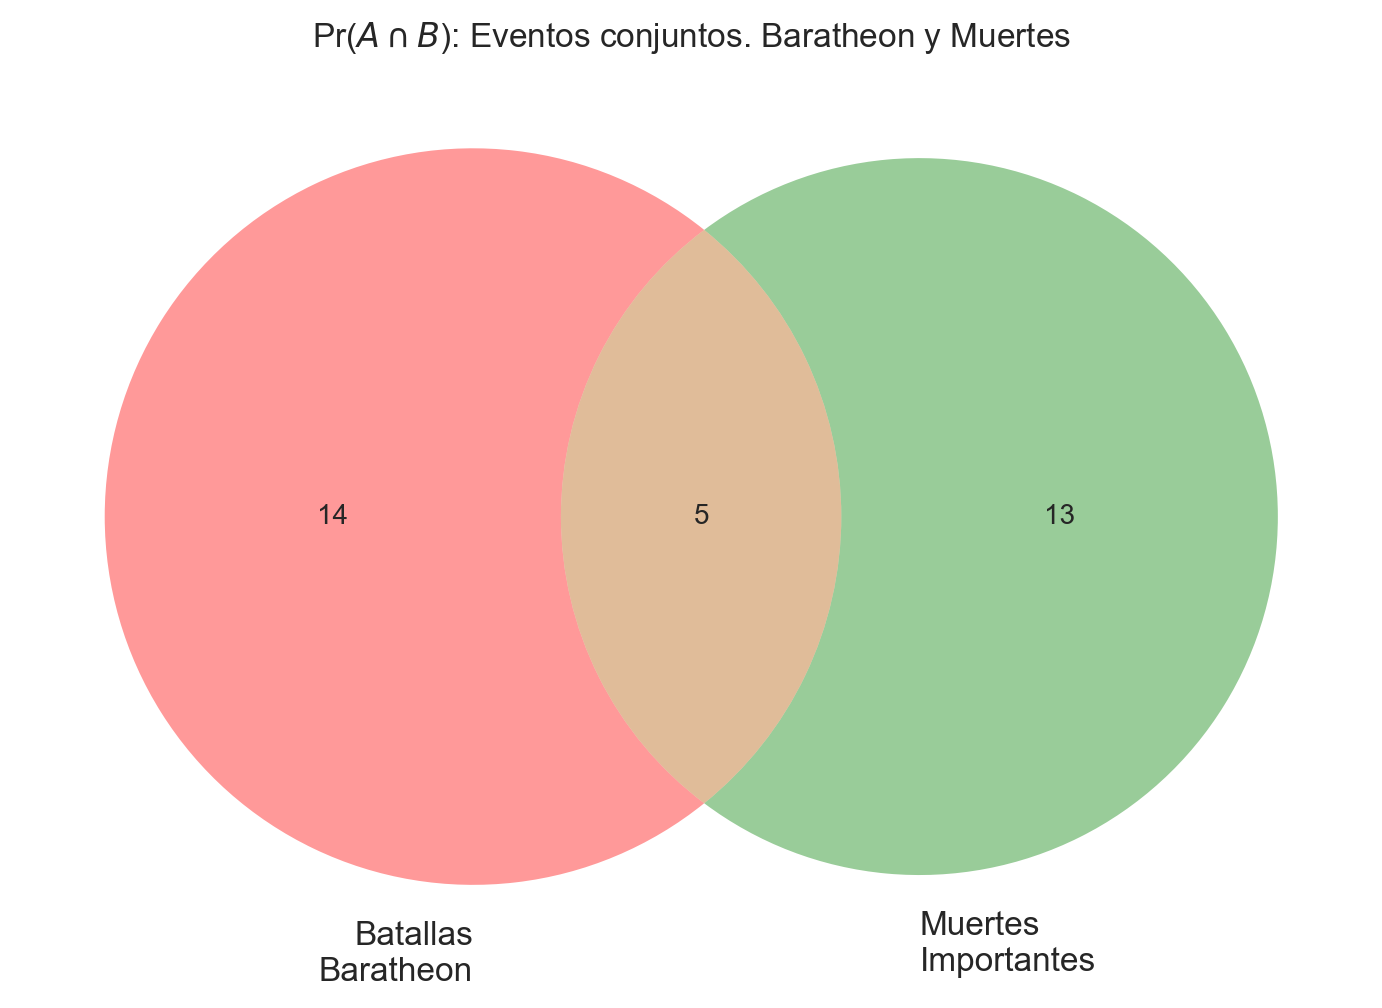

In [22]:
gfx.graph_venn()

In [21]:
print("Cantidad de muertes importantes en batallas Baratheon: ", muerte_baratheon)
print("Pr(Muerte | Baratheon): ", muerte_baratheon / len(df))

Cantidad de muertes importantes en batallas Baratheon:  5
Pr(Muerte | Baratheon):  0.13157894736842105


* Podríamos estar tentados a interpretar este 13% como la probabilidad condicional del evento, pero hay que considerar que ésta cifra se calcula en comparación a la muestra, no con la muestra de las batallas iniciadas por Baratheons. Por eso es que ajustamos (i.e: dividimos) por las batallas Baratheon.

In [14]:
batallas_baratheon = df['attacker_king'].value_counts()[0]
print("Pr(Muerte|Baratheon):", muerte_baratheon / batallas_baratheon)

Pr(Muerte|Baratheon): 0.35714285714285715


* Así, observamos que _dentro de todas las batallas iniciadas por un Baratheon, la probabilidad que un personaje importante muera es del 35%_.

# Funciones


Las funciones nos permiten abstraernos del código para resolver un problema. Una vez que tenemos definida un función podemos simplemente llamarla cuando la necesitemos. Las definiremos y/o ocuparemos funciones definidas por otros todo el tiempo, es muy importante que aprendamos bien su uso y sintaxis.

Por ejemplo podemos crear una función para calcular la hipotenusa.

In [58]:
import math

def hipotenusa(x, y):
    tmp = (x ** 2 + y ** 2)
    tmp = math.sqrt(tmp)
    return(tmp)
  

y luego podemos calcular la hipotenusa de cualquier conjunto de catetos utilizando:


In [44]:
hipotenusa(3,4)

5.0

Este principio de abstracción es muy importante para crear código ordenado y que podamos reutilizar cada vez que tengamos una situación similar.

## El principio DRY
* Uno de los principios básicos de la programación es el __DRY:__ __D__on't __R__epeat __Y__ourself. Si vamos a utilizar una expresión más de 2 veces, es mejor generar una función a partir de ella. No solo es una práctica inteligente, también evita problemas en el código al compartir definiciones y procedimientos

* Dada la amable naturaleza sintáctica de Python, generarlas es muy fácil.
* Generemos nuestra primera función. Lo que deseamos es que la función nos salude cuando la invoquemos.

## Creando nuestra primera función

In [16]:
def saludar():
    print('Hola Mundo!')

saludar()

Hola Mundo!


## Anatomía mínima de una función

La definición de una función se compone de los siguientes elementos:

1. Declaración `def`: Mediante ella señalamos que todo lo escrito será considerado como una función.
- Nombre de la función `saludar()`: Este es el identificador que utilizaremos para llamarla posteriormente. Cabe destacar que los paréntesis y el doble punto al final de la función son obligatorias.
- La indentación (sangrado) es parte importante, le permite a python saber que parte del código escrito pertenece a la función.
- Expresiones a ejecutar `print('Hola Mundo!')` estas expresiones tienne que estar correctamente indentadas, el estándar es de __4 espacios__.

### ¿Qué sucede si no indentamos?

hay dos situaciones posibles, la primera es que la función no tenga ningún bloque identado, esto mostrará un error.


In [52]:
def saludar():
print("esto no se imprimirá porque hay un error")

saludar()

IndentationError: expected an indented block (<ipython-input-52-9e079350a778>, line 2)

La segunda opción es que parte de la función quede fuera de la función.

In [59]:
def saludar():
    print("este código si pertenece a la función")
    print("este código si pertenece a la función")
print("este código no pertenece a la función")
saludar()
saludar()
saludar()


este código no pertenece a la función
este código si pertenece a la función
este código si pertenece a la función
este código si pertenece a la función
este código si pertenece a la función
este código si pertenece a la función
este código si pertenece a la función


## Parámetros

Para que las funciones sean flexibles pueden recibir parámetros.

Por ejemplo podríamos hacer mucho mas flexible la función de saludar si le pasamos como parámetro el saludo.

In [46]:
def saludar(saludo):
    print(saludo)

saludar("hola")
saludar("hola mundo")

hola
hola mundo


Una función puede recibir múltiples parámetros separados por una `,` cada uno.

In [60]:
def saludar(saludo1, saludo2):
    print(saludo1)
    print(saludo2)

saludar("hola", "mundo")

hola
mundo


### Los parámetros son obligatorios

Si una función recibe parámetros y nos los especificamos obtendremos un error.


In [86]:
def saludar(saludo1, saludo2):
    print(saludo1)
    print(saludo2)

saludar("hola")

TypeError: saludar() missing 1 required positional argument: 'saludo2'

### Parámetros con valores por defecto

En algunos casos es muy útil que una función reciba un valor por defecto.

In [81]:
def saludar(saludo1, saludo2="valor por defecto"):
    print(saludo1, saludo2)
    
saludar("hola")
saludar("hola", "valor ingresado manualmente")

hola valor por defecto
hola valor ingresado manualmente


## El retorno

Las funciones pueden devolver valores con los que podemos seguir trabajando, veamos un ejemplo muy sencillo.

In [1]:
def incrementar(a, b = 1):
  return a + b


print(incrementar(2))
print(incrementar(5, 4))

3
9


Las funciones normalmente devuelven un valor o lo muestran en pantalla. Son muy poco frecuentes los casos distintos.


# De la fórmula a python

Es importante que aprendamos a convertir una ecuación matemática a una función de python.
Para empezar recalculemos la hipotenusa.

$$
\text{Hipotenusa} = \sqrt{x^{2} + y^{2}}
$$

Escribir el código para resolver el problema es sencillo, elevamos dos números al cuadrado y luego sacamos la raíz de la suma. Por ejemplo para los catetos de tamaño 3 y 4 lo calcularíamos como: 

In [80]:
np.sqrt((3 **2 + 4 ** 2))

5.0

Para poder reutilizar el código necesitamos entender, cualos son los valores de ingreso, y los de salida. 
Si queremos calcular la hipotenusa a partir de los catetos entonces los catetos son la entrada y la hipotenusa la salida.


In [85]:
import math as np
def hypotenuse(x, y):
    return np.sqrt((x **2 + y ** 2))
print(hypotenuse(3, 4))

5.0


## Aplicando funciones

* Ahora vamos a generar una serie de funciones para sistematizar nuestro análisis de las batallas.
* Consideremos los siguientes objetivos:
    - Deseamos una función que nos entregue las medidas de dispersión para las variables contínuas, y que entregue una excepción en las strings.
    - Generar una función para calcular las probabilidades condicionales en base a dos atributos.
    
### Función descriptiva

#### Primer Intento: llamando funciones

* Nuestro primer intento para esta función es incluír dentro del cuerpo de la función todas las llamadas a las funciones que aprendimos en la primera semana: `np.mean` para estimar la media, `stats.mode` para la moda y `np.std` para la desviación.
* Con estos valores podemos tener una visión general del cómo se comporta la variable en cuanto a tendencia y dispersión.

In [23]:
def fetch_descriptives(x):
    np.mean(x)
    stats.mode(x)
    np.std(x)
    
fetch_descriptives(df['attacker_size'])

* Si llamamos a `fetch_descriptives`, no obtendremos respuesta alguna dado que olvidamos incluír `print` o `return`. Refactorizemos en un segundo intento.
* Una salvedad, esto no implica que el cuerpo de la función no se haya ejecutado.

#### Segundo intento: incluir prints

* Nuestra función falla en reportar cualquier cálculo. Para ello utilizaremos `prints` en cada llamada para devolver el valor de cada función.

In [24]:
def fetch_descriptives(x):
    print(np.mean(x))
    print(stats.mode(x))
    print(np.std(x))
    
fetch_descriptives(df['attacker_size'])

9942.541666666666
ModeResult(mode=array([6000.]), count=array([3]))
19856.031772442948


* Ahora si obtenemos resultados sobre la variable `attacker_size`. Un percance es que los datos se retornan en strings. ¿Qué pasa si deseamos que la función retorne valores asignables a objetos?

#### Tercer intento: generando objetos dentro de la función

* Para resolver el problema descrito, podemos asignar un objeto a cada función ejecutada en el cuerpo de la función. De esta forma obtenemos resultados más flexibles.
* Para que nuestra función retorne las variables, es necesario utilizar `return`.

In [29]:
def fetch_descriptives(x):
    mu = np.mean(x)
    mode = stats.mode(x)
    sigma = np.std(x)
    return mu, mode, sigma

In [30]:
fetch_descriptives(df['attacker_size'])

(9942.541666666666,
 ModeResult(mode=array([6000.]), count=array([3])),
 19856.031772442948)

* Si ejecutamos la función y no asignamos su resultado a una variable, obtendremos exactamente lo mismo.

In [31]:
resultado = fetch_descriptives(df['attacker_size'])
resultado

(9942.541666666666,
 ModeResult(mode=array([6000.]), count=array([3])),
 19856.031772442948)

* Pero si asignamos la misma cantidad de variables que de resultados de la función, obtendremos algo mucho más trabajable

In [32]:
media, moda, varianza = fetch_descriptives(df['attacker_size'])
print(media)
print(moda)
print(varianza)

9942.541666666666
ModeResult(mode=array([6000.]), count=array([3]))
19856.031772442948


#### Cuarto intento:

* Ya estamos un poco más encaminados con nuestra función, pero hay una serie de detalles:
1. Los números se presentan en formatos incomprensibles: Para ello redondearemos la media y la varianza, y selecionaremos el valor correspondiente a la moda.
2. Nuestra función todavía no genera el mensaje para los strings.

##### Reordenando números

In [33]:
def fetch_descriptives(x):
    # utilizamos round para redondear al tercer decimal
    mu = round(np.mean(x), 3)
    # solicitamos primer elemento (6000) dentro del primer resultado de la moda
    mode = stats.mode(x)[0][0]
    # utilizamos round para redondear al tercer decimal
    sigma = round(np.std(x), 3)
    return mu, mode, sigma

media, moda, varianza = fetch_descriptives(df['attacker_size'])
print(media)
print(moda)
print(varianza)

9942.542
6000.0
19856.032


##### Generando el mensaje para los strings

* Para establecer un método diferenciador entre strings y no strings, debemos encontrar un método que difiera entre dato numérico y no numérico.
* `pandas` ofrece una serie de métodos dentro de `pd.api.types`. Dentro de ésta, está el método `is_numeric_dtype` que entrega un booleano.

In [72]:
pd.api.types.is_numeric_dtype(df['attacker_size'])

True

* El método mencionado arriba se encapsulará en un `if` para discriminar entre datos numéricos y no numéricos.

In [73]:
def fetch_descriptives(x):
    if pd.api.types.is_numeric_dtype(x) is True:
        mu = round(np.mean(x), 3)
        mode = stats.mode(x)[0][0]
        sigma = round(np.std(x), 3)
        return mu, mode, sigma
    else:
        print("No se puede operar en strings")

In [74]:
fetch_descriptives(df['attacker_king'])

No se puede operar en strings


In [75]:
fetch_descriptives(df['attacker_size'])

(9942.542, 6000.0, 19856.032)

In [82]:
def fetch_descriptives(x, pretty_print=False):
    if pd.api.types.is_numeric_dtype(x) is True:
        mu = round(np.mean(x), 3)
        mode = stats.mode(x)[0][0]
        sigma = round(np.std(x), 3)
    else:
        print("No se puede operar en strings")
        
    if pretty_print is True:
        print("La media para ", x.name, " es de ", mu )
        print("La moda para ", x.name, " es de ", mode)
        print("La desviación estandar para ", x.name, " es de ", sigma)
    else:
        return mu, mode, sigma

In [83]:
fetch_descriptives(df['attacker_size'], pretty_print=True)

La media para  attacker_size  es de  9942.542
La moda para  attacker_size  es de  6000.0
La desviación estandar para  attacker_size  es de  19856.032


In [86]:
m, mod, s = fetch_descriptives(df['attacker_size'])
print(m)
print(mod)
print(s)

9942.542
6000.0
19856.032


### Función para estimar probabilidades condicionales

* Nuestro segundo objetivo es el refactorizar el procedimiento para obtener probabilidades condicionales. Sabemos que para obtener la probabilidad condicional de $A$ en $B$ necesitamos dos cifras:

- $\text{Pr}(A \cup B)$: La probabilidad de ambos eventos sucedan en el espacio muestral. Eso lo obteníamos con el siguiente flujo:
    
```python
muerte_baratheon = 0
for i, r in df.iterrows():
        if (r['attacker_king'] == 'Joffrey/Tommen Baratheon' and r['major_death'] == 1):
        muerte_baratheon += 1
```
- $\text{Pr}(B)$: La probabilidad de ocurrencia específica en B:

```python
batallas_baratheon = df['attacker_king'].value_counts()[0]
```

- $\text{Pr}(A | B) = \frac{\text{Pr}(A \cup B)}{\text{Pr}(B)}$: La razón entre ambos eventos:
    
```python
print("Pr(Muerte|Baratheon):", muerte_baratheon / batallas_baratheon)
```

* Para generar nuestra función debemos establecer todos los parámetros necesarios. Cabe destacar que _todos los eventos son ocurrencias __específicas__ dentro de las variables_. De esta manera, nuestra función necesita de cinco parámetros:
    
    1. El evento específico A. `A_var`
    2. La variable donde A pertenece. `A_condition`
    3. El evento específico B. `B_var`
    4. La variable donde B pertenece. `B_condition`
    5. La tabla de datos donde todos los datos se encuentran localizados. `df`

In [44]:
def conditional_pr(df, A_var, A_condition, B_var, B_condition):
    
    get_a_and_b = 0
    
    for i, r in df.iterrows():
        if (r[A_var] == A_condition and r[B_var] == B_condition):
            get_a_and_b += 1
    
    get_b_pr = df[B_var].value_counts().loc[B_condition]
    
    print("Pr(", A_condition, "|", B_condition, ")", (get_a_and_b / get_b_pr))

* La prueba de fuego de la función es que estime la misma probabilidad que en nuestro código a mano:

In [46]:
refactor_pr = conditional_pr(df, A_condition=1, 
               A_var='major_death', 
               B_condition='Joffrey/Tommen Baratheon', 
               B_var='attacker_king')
original_pr = muerte_baratheon / batallas_baratheon
print("Hardcoded: ",original_pr)

Pr( 1 | Joffrey/Tommen Baratheon ) 0.35714285714285715
Hardcoded:  0.35714285714285715


* Una buena práctica es el agregar `docstring` a nuestras funciones. Esto permite insertar documentación dentro de la misma para explicar y definir los parámetros y su uso.
* Los `docstring` se incluyen _después de la declaración de función y antes del cuerpo de la función_. Se deliminan mediante `"""` y se cierran con otros `"""`

In [3]:
def conditional_pr(df, A_var, A_condition, B_var, B_condition):
    """
    conditional_pr: retrieve conditional probability given the following formula:
    
                                Pr(A and B)
                    Pr(A|B) = --------------
                                    Pr(B)
    
    parameters:
        `df`: dataframe.
        `A_var`: event to be conditioned by B.
        `A_condition`: specific outcome on A.
        `B_var`: conditioning event on A.
        `B_condition`: specific conditioning event on B.
        
    """
    
    get_a_and_b = 0
    
    for i, r in df.iterrows():
        if (r[A_var] == A_condition and r[B_var] == B_condition):
            get_a_and_b += 1
    
    get_b_pr = df[B_var].value_counts().loc[B_condition]
    
    print("Pr(", A_condition, "|", B_condition, ")", (get_a_and_b / get_b_pr))

In [4]:
print(conditional_pr.__doc__)


    conditional_pr: retrieve conditional probability given the following formula:
    
                                Pr(A and B)
                    Pr(A|B) = --------------
                                    Pr(B)
    
    parameters:
        `df`: dataframe.
        `A_var`: event to be conditioned by B.
        `A_condition`: specific outcome on A.
        `B_var`: conditioning event on A.
        `B_condition`: specific conditioning event on B.
        
    


* Esto es análogo a nuestro método `Shift + Tab` con Jupyter

In [87]:
refactor_pr = conditional_pr(df, A_condition=1, 
               A_var='major_death', 
               B_condition='Joffrey/Tommen Baratheon', 
               B_var='attacker_king')

Pr( 1 | Joffrey/Tommen Baratheon ) 0.35714285714285715
